This is the code for the paper:

# [Statistics of Deep Generated Images](https://arxiv.org/pdf/1708.02688.pdf)

This demo computes statistics of only 40 images, so the results will be different from those in the paper, which was computed over 12,800 images. 

## GAN with sub-pixel convolution
We find that the generated images have a spiky mean power spectrum, see [the section of Power spectrum](#power-spectrum). Replacing deconvolution layers in the model by sub-pixel convolution helps them generate images with a mean power spectrum more similar to the mean power spectrum of natural images. We did this modification to WGAN[1] model and provide it here (implemented in PyTorch). Try it:
```shell
python -m visdom.server
python main.py --ipath path/to/training/images --opath path/to/save/checkpoints
```

then open [http://localhost:8097/env/main](http://localhost:8097/env/main) to visulize the training process

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
from myfunc import *
import os
import scipy.optimize as opt
import scipy.stats as stats

%matplotlib inline

In [8]:
# path to training images should be the first element
imgRoots = ['./imagenet/training',
            './imagenet/dcgan',
            './imagenet/wgan']
tags = ['imagenet', 'idcgan', 'iwgan']

## Luminance distribution

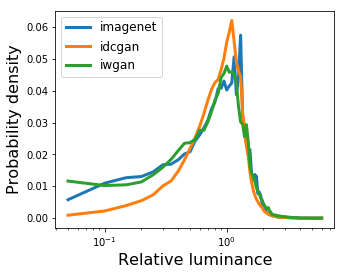

In [9]:
matplotlib.rcParams['figure.figsize'] = (5, 4)
output_root = './imagenet/results/lum'
if not os.path.exists(output_root):
    os.mkdir(output_root)
fig = plt.figure()
for tag, img_root in zip(tags, imgRoots):
    h, b, s = luminance_distribution(img_root, output_root, tag )
    plt.plot(b[1:], h/h.sum(), linewidth=3.0, label=tag)
plt.legend(fontsize=12)
plt.xscale('log')
plt.ylabel('Probability density', fontsize=16)
plt.xlabel('Relative luminance', fontsize=16)
plt.show()

Skewness of the tree luminance distributions can be find in output_root.

We can apply t-test to these values to see if there's a statistically significant difference between the skewness of training images and generated images. 

In [10]:
train_stat = output_root + '/' + tags[0] +'_lum_skew.npz'

train_stat = np.load(train_stat)['arr_0']
output_name = open(output_root + '/train_ave.txt', 'w')
print 'average skewness of training images is %.4f \n' % train_stat.mean()
output_name.write('skewness: %.4f \n' % train_stat.mean())
output_name.close()

for tag in tags[1:]:
    output_name = open(output_root + '/' + tag + '_stat_test.txt', 'w')
    gen_stat = np.load(output_root + '/'  +tag + '_lum_skew.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat, gen_stat, equal_var=False)
    print 'average skewness of %s is %.4f, ' % (tag, gen_stat.mean())
    print 't-statistic: %.4f, p-value: %.4f\n' % (statistic, pvalue)
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))
    output_name.close()

average skewness of training images is 0.0095 

average skewness of idcgan is 0.0514, 
t-statistic: -0.2785, p-value: 0.7812

average skewness of iwgan is 0.1987, 
t-statistic: -1.1961, p-value: 0.2347



## Contrast distribution
and its Weibull fit

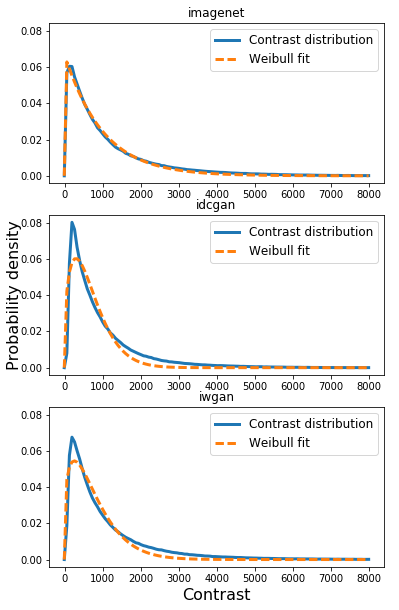

In [11]:
matplotlib.rcParams['figure.figsize'] = (6.0, 10.0)
fig, axes = plt.subplots(3, 1, sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
it = 0
for tag, img_root in zip(tags, imgRoots):
    h, b = contrast_distribution(img_root)
    axes[it].plot(b[1:], h/h.sum(), linewidth=3.0, label='Contrast distribution')
    popt, pcov = opt.curve_fit(my_weibull, np.arange(len(h))[1:], h[1:])  # throw away x=0!
    axes[it].plot(b[1:], my_weibull(np.arange(len(h)), *popt)/h.sum(), linewidth=3.0, linestyle='dashed', label='Weibull fit')
    axes[it].set_title(tag)
    axes[it].legend(fontsize=12)
    it += 1
plt.ylabel('Probability density', fontsize=16)
plt.xlabel('Contrast', fontsize=16)
plt.show()

Compute parameters of the fitted Weibull distribution and the t-test results

In [12]:
output_root = './imagenet/results/contrast_parameters'
if not os.path.exists(output_root):
    os.mkdir(output_root)

for tag, img_root in zip(tags, imgRoots):
    weibull_contrast_param(img_root, output_root, tag)

train_stat = [(output_root + '/' + tags[0] +'_c.npz'),  # \gamma in the paper
              (output_root + '/' + tags[0] +'_s.npz'),  # \beta in the paper
              (output_root + '/' + tags[0] +'_kld.npz')]

output_name = open(output_root + '/train_ave.txt', 'w')

train_stat0 = np.load(train_stat[0])['arr_0']
train_stat1 = np.load(train_stat[1])['arr_0']
train_stat2 = np.load(train_stat[2])['arr_0']

output_name = open(output_root + '/train_ave.txt', 'w')
print 'average c, s, kld of training images: %.4f, %.4f, %.4f\n' \
% (train_stat0.mean(), train_stat1.mean(), train_stat2.mean())
output_name.write('c: %.4f' % train_stat0.mean())
output_name.write('s: %.4f' % train_stat1.mean())
output_name.write('kld: %.4f' % train_stat2.mean())
output_name.close()

for tag in tags[1:]:
    output_name = open(output_root + '/' + tag + '_stat_test.txt', 'w')
    gen_stat = np.load(output_root + '/'  +tag + '_c.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat0, gen_stat, equal_var=False)
    print tag
    print 'average c: %.4f, t-tatistics: %.4f, p-value: %.4f' \
    % (gen_stat.mean(), statistic, pvalue)
    output_name.write('c\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_s.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat1, gen_stat, equal_var=False)
    print 'average s: %.4f, t-tatistics: %.4f, p-value: %.4f' \
    % (gen_stat.mean(), statistic, pvalue)
    output_name.write('s\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_kld.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat2, gen_stat, equal_var=False)
    print 'average kld: %.4f, t-tatistics: %.4f, p-value: %.4f\n' \
    % ( gen_stat.mean(), statistic, pvalue)
    output_name.write('kld\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    output_name.close()

/home/xyz/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:1558: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))
/home/xyz/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:2512: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=0)


average c, s, kld of training images: 1.1240, 1277.7882, 1.7906

idcgan
average c: 1.1973, t-tatistics: -1.8492, p-value: 0.0678
average s: 1065.3428, t-tatistics: 2.9552, p-value: 0.0041
average kld: 1.5980, t-tatistics: 1.4806, p-value: 0.1426

iwgan
average c: 1.1466, t-tatistics: -0.6623, p-value: 0.5094
average s: 1199.9541, t-tatistics: 0.9571, p-value: 0.3410
average kld: 1.6530, t-tatistics: 1.0841, p-value: 0.2817



## Random filter response distribution

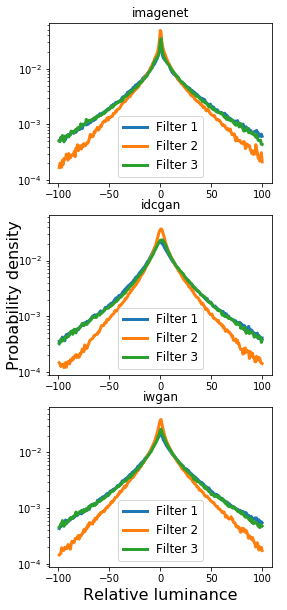

In [14]:
matplotlib.rcParams['figure.figsize'] = (4.0, 10.0)
output_root = './imagenet/results/filter_response'
if not os.path.exists(output_root):
    os.mkdir(output_root)

np.random.seed(0)
kernel1 = np.random.uniform(size=(8, 8))
kernel1 = (kernel1 - kernel1.mean()) / np.sqrt(((kernel1 - kernel1.mean()) ** 2).sum())
np.random.seed(1)
kernel2 = np.random.uniform(size=(8, 8))
kernel2 = (kernel2 - kernel2.mean()) / np.sqrt(((kernel2 - kernel2.mean()) ** 2).sum())
np.random.seed(2)
kernel3 = np.random.uniform(size=(8, 8))
kernel3 = (kernel3 - kernel3.mean()) / np.sqrt(((kernel3 - kernel3.mean()) ** 2).sum())

fig, axes = plt.subplots(3, 1, sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
it = 0
for tag, img_root in zip(tags, imgRoots):
    h, b, k = random_filter_response_distribution(img_root, kernel1, output_root, tag+'_filter1')
    axes[it].plot(b[1:], h/h.sum(), linewidth=3.0, label='Filter 1')
    
    h, b, k = random_filter_response_distribution(img_root, kernel2, output_root, tag+'_filter2')
    axes[it].plot(b[1:], h/h.sum(), linewidth=3.0, label='Filter 2')
    h, b, k = random_filter_response_distribution(img_root, kernel3, output_root, tag+'_filter3')
    axes[it].plot(b[1:], h/h.sum(), linewidth=3.0, label='Filter 3')
    axes[it].set_title(tag)
    axes[it].legend(fontsize=12)
    axes[it].set_yscale('log')
    it += 1
plt.ylabel('Probability density', fontsize=16)
plt.xlabel('Relative luminance', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Compute kurtosis of ramdom filter response and appy t-test to them

In [15]:
train_stat = [(output_root + '/' + tags[0] +'_filter1.npz'),  # \gamma in the paper
              (output_root + '/' + tags[0] +'_filter2.npz'),  # \beta in the paper
              (output_root + '/' + tags[0] +'_filter3.npz')]

output_name = open(output_root + '/train_ave.txt', 'w')

train_stat0 = np.load(train_stat[0])['arr_0']
train_stat1 = np.load(train_stat[1])['arr_0']
train_stat2 = np.load(train_stat[2])['arr_0']

output_name = open(output_root + '/train_ave.txt', 'w')
print 'average kurtosis of three filter responses of training images: %.4f, %.4f, %.4f\n' \
% (train_stat0.mean(), train_stat1.mean(), train_stat2.mean())
output_name.write('filter1: %.4f ' % train_stat0.mean())
output_name.write('filter2: %.4f ' % train_stat1.mean())
output_name.write('filter3: %.4f ' % train_stat2.mean())
output_name.close()

for tag in tags[1:]:
    output_name = open(output_root + '/' + tag + '_stat_test.txt', 'w')
    gen_stat = np.load(output_root + '/'  +tag + '_filter1.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat0, gen_stat, equal_var=False)
    print tag
    print 'kurtosis of filter1 response: %.4f, t-tatistics: %.4f, p-value: %.4f' \
    % (gen_stat.mean(), statistic, pvalue)
    output_name.write('filter1\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_filter2.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat1, gen_stat, equal_var=False)
    print 'kurtosis of filter2 response: %.4f, t-tatistics: %.4f, p-value: %.4f' \
    % (gen_stat.mean(), statistic, pvalue)
    output_name.write('filter2\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_filter3.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat2, gen_stat, equal_var=False)
    print 'kurtosis of filter3 response: %.4f, t-tatistics: %.4f, p-value: %.4f\n' \
    % ( gen_stat.mean(), statistic, pvalue)
    output_name.write('filter3\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    output_name.close()

average kurtosis of three filter responses of training images: 6.0516, 5.7094, 5.8418

idcgan
kurtosis of filter1 response: 7.2213, t-tatistics: -1.4318, p-value: 0.1554
kurtosis of filter2 response: 7.5278, t-tatistics: -2.4741, p-value: 0.0151
kurtosis of filter3 response: 6.1615, t-tatistics: -0.4489, p-value: 0.6546

iwgan
kurtosis of filter1 response: 5.9391, t-tatistics: 0.1574, p-value: 0.8753
kurtosis of filter2 response: 5.9612, t-tatistics: -0.3916, p-value: 0.6962
kurtosis of filter3 response: 5.6263, t-tatistics: 0.3126, p-value: 0.7553



## Power spectrum

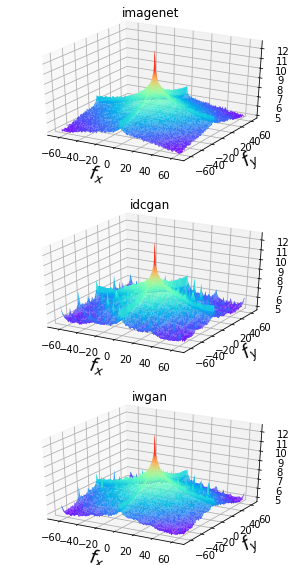

In [16]:
matplotlib.rcParams['figure.figsize'] = (4.0, 10.0)
output_root = './imagenet/results/spec'
if not os.path.exists(output_root):
    os.mkdir(output_root)


fig = plt.figure(figsize=plt.figaspect(2.))
it = 1
for tag, img_root in zip(tags, imgRoots):
    f_img = average_power_spectrum(img_root, output_root, tag)
    img_size = 128

    """surface plot"""
    ax = fig.add_subplot(3, 1,it, projection='3d')
    x = np.arange(-img_size / 2, img_size / 2, 1)
    y = np.arange(-img_size / 2, img_size / 2, 1)
    x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y,  np.log10(np.fft.fftshift(f_img)), rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
    ax.set_xlabel('$f_x$', fontsize=18)
    ax.set_ylabel('$f_y$', fontsize=18)
    ax.set_title(tag)
    handles, labels = ax.get_legend_handles_labels()
    ax.grid('on')
    it += 1

compute parameters of the power spectra and the t-test results

In [17]:
train_stat = [output_root + '/' + tags[0] +'_alpha_x.npz',  # \gamma in the paper
              output_root + '/' + tags[0] +'_alpha_y.npz',  # \beta in the paper
              output_root + '/' + tags[0] +'_a_x.npz',
              output_root + '/' + tags[0] +'_a_y.npz',
              output_root + '/' + tags[0] +'_res_x.npz',
              output_root + '/' + tags[0] +'_res_y.npz']

train_stat0 = np.load(train_stat[0])['arr_0']
train_stat1 = np.load(train_stat[1])['arr_0']
train_stat2 = np.load(train_stat[2])['arr_0']
train_stat3 = np.load(train_stat[3])['arr_0']
train_stat4 = np.load(train_stat[4])['arr_0']
train_stat5 = np.load(train_stat[5])['arr_0']

output_name = open(output_root + '/train_ave.txt', 'w')
print 'training images'
print 'alpha_x: %.4f' % train_stat0.mean()
print 'alpha_y: %.4f' % train_stat1.mean()
print 'a_x: %.4f' % train_stat2.mean()
print 'a_y: %.4f' % train_stat3.mean()
print 'res_x: %.4f' % train_stat4.mean()
print 'res_y: %.4f\n' % train_stat5.mean()

output_name.write('alpha_x: %.4f ' % train_stat0.mean())
output_name.write('alpha_y: %.4f ' % train_stat1.mean())
output_name.write('a_x: %.4f ' % train_stat2.mean())
output_name.write('a_y: %.4f ' % train_stat3.mean())
output_name.write('res_x: %.4f ' % train_stat4.mean())
output_name.write('res_y: %.4f ' % train_stat5.mean())
output_name.close()

for tag in tags[1:]:
    output_name = open(output_root + '/' + tag + '_stat_test.txt', 'w')
    gen_stat = np.load(output_root + '/'  +tag + '_alpha_x.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat0, gen_stat, equal_var=False)
    print tag
    print 'alpha_x: %.4f, t-statistics: %.4f, p-value: %.4f' \
           %(gen_stat.mean(), statistic, pvalue)
    output_name.write('alpha_x\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_alpha_y.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat1, gen_stat, equal_var=False)
    print 'alpha_y: %.4f, t-statistics: %.4f, p-value: %.4f' \
           %(gen_stat.mean(), statistic, pvalue)
    output_name.write('alpha_y\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_a_x.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat2, gen_stat, equal_var=False)
    print 'a_x: %.4f, t-statistics: %.4f, p-value: %.4f' \
           %(gen_stat.mean(), statistic, pvalue)
    output_name.write('a_x\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_a_y.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat3, gen_stat, equal_var=False)
    print 'a_y: %.4f, t-statistics: %.4f, p-value: %.4f' \
           %(gen_stat.mean(), statistic, pvalue)
    output_name.write('a_y\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_res_x.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat4, gen_stat, equal_var=False)
    print 'res_x: %.4f, t-statistics: %.4f, p-value: %.4f' \
           %(gen_stat.mean(), statistic, pvalue)
    output_name.write('res_x\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    gen_stat = np.load(output_root + '/'  +tag + '_res_y.npz')['arr_0']
    statistic, pvalue = stats.ttest_ind(train_stat5, gen_stat, equal_var=False)
    print 'res_y: %.4f, t-statistics: %.4f, p-value: %.4f' \
           %(gen_stat.mean(), statistic, pvalue)
    output_name.write('res_y\n')
    output_name.write('average: %.4f, ' % gen_stat.mean())
    output_name.write('statistic: %.4f, pvalue: %.4f\n' % (statistic, pvalue))

    output_name.close()

training images
alpha_x: -1.9945
alpha_y: -1.9811
a_x: 9.2742
a_y: 9.3285
res_x: 1.6136
res_y: 1.4366

idcgan
alpha_x: -1.8806, t-statistics: -2.0589, p-value: 0.0422
alpha_y: -1.8046, t-statistics: -3.3152, p-value: 0.0013
a_x: 8.9738, t-statistics: 3.8985, p-value: 0.0002
a_y: 8.9782, t-statistics: 5.0259, p-value: 0.0000
res_x: 2.3746, t-statistics: -3.4458, p-value: 0.0009
res_y: 1.6308, t-statistics: -0.9873, p-value: 0.3260
iwgan
alpha_x: -1.9443, t-statistics: -0.9947, p-value: 0.3225
alpha_y: -1.9928, t-statistics: 0.2381, p-value: 0.8123
a_x: 9.1946, t-statistics: 1.0935, p-value: 0.2769
a_y: 9.3006, t-statistics: 0.4227, p-value: 0.6735
res_x: 1.2995, t-statistics: 1.9930, p-value: 0.0499
res_y: 1.3130, t-statistics: 0.7450, p-value: 0.4586


## Reference
[1] Arjovsky, Martin, Soumith Chintala, and Léon Bottou. "Wasserstein gan." arXiv preprint arXiv:1701.07875 (2017).